In [2]:
import pyperclip
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time

import numpy as np
import matplotlib.pyplot as plt

import sys, os

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

me.mechanics_printing()

#### Create Symbols

In [100]:
from sympy.abc import x,y,z
DoFs = 5          # total degrees of freedom

p = ma.DynamicModelParameters(DoFs)
p.h = ma.ModelSymbol(string = 'h')

p.m = ma.ModelSymbol(string = 'm')
p.I_xx = ma.ModelSymbol(string = 'I_xx')
p.I_yy = ma.ModelSymbol(string = 'I_yy')
p.I_zz = ma.ModelSymbol(string = 'I_zz')

p.X = ma.ModelSymbol(string = 'X')
p.Y = ma.ModelSymbol(string = 'Y')
p.Z = ma.ModelSymbol(string = 'Z')
p.L = ma.ModelSymbol(string = 'L')
p.M = ma.ModelSymbol(string = 'M')
p.N = ma.ModelSymbol(string = 'N')
p.tau = ma.ModelSymbol(string = 'tau')

# Attitude Parmas
# p.rho = ma.ModelSymbol(value = 1.225,string = 'rho')                 # density
# p.V = ma.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.alpha  = ma.ModelSymbol(value = 0,string = 'alpha')                     # gravity
p.Lambda  = ma.ModelSymbol(value = 0,string = 'Lambda')                     # gravity
p.theta  = ma.ModelSymbol(value = 0,string = 'theta')                     # gravity
p.b  = ma.ModelSymbol(value = 1,string = 'b')                     # gravity

#### Create Coordinate Systems

In [101]:
tether_frame = ma.HomogenousTransform().R_z(p.q[0]).R_x(-p.q[1]+sym.pi).Translate(0,0,p.h)
tether2body = ma.HomogenousTransform().R_x(p.q[2]).R_z(p.q[4]).R_y(p.q[3])
body_frame = (tether_frame*tether2body).simplify()
#Generate Mass Matrices
M = ele.MassMatrix(p.m, I_xx = 0, I_yy=0, I_zz=0)

# Generate Rigid Elements
aircraft_mass = ele.RigidElement(tether_frame,M,gravityPotential=True, simplify=True)
#tether_spring = ele.Spring(p.q[2],p.K)

In [102]:
# Generate Aircraft external forces
F = tether2body.InvAdjoint().T*sym.Matrix([p.X+p.tau,p.Y,p.Z,p.L,p.M,p.N])
aircraft_forces_tether = ef.BodyForce(p,tether_frame,Fx=F[0],Fy=F[1],Fz=F[2],Mx=F[3])


aircraft_forces_self = ef.BodyForce(p,tether2body,Fx=p.X,Fy=p.Y,Fz=p.Z,Mx=p.L,My=p.M,Mz=p.N)


external_forces = ef.CompositeForce([aircraft_forces_tether,aircraft_forces_self])

In [113]:
sm = ma.SymbolicModel.FromElementsAndForces(p,[aircraft_mass],ExtForces=external_forces)

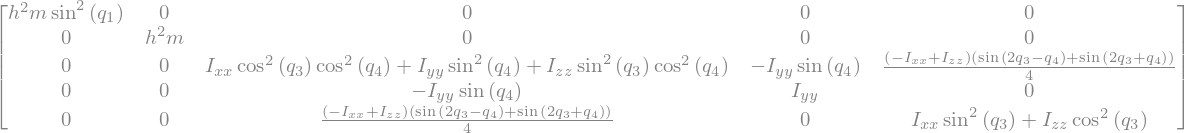

In [114]:
# augment mass matrix with model inertias
M2 = ele.MassMatrix(p.m, I_xx = p.I_xx, I_yy=p.I_yy, I_zz=p.I_zz)
aircraft_inertia = ele.RigidElement(tether2body,M2,gravityPotential=True, simplify=True)
sm2 = ma.SymbolicModel.FromElementsAndForces(p,[aircraft_inertia])
sm.M = sym.simplify(sm.M +sm2.M)
sm.M

In [115]:
t = me.dynamicsymbols._t
xi = me.dynamicsymbols('xi')
sigma = me.dynamicsymbols('sigma')
mu = me.dynamicsymbols('mu')
beta = me.dynamicsymbols('beta')
alpha = me.dynamicsymbols('alpha')
qs = [xi,sigma,mu,alpha,beta]

In [116]:
small_angles = {**{sym.sin(p.q[i]):p.q[i]for i in [2,3,4]},**{sym.cos(p.q[i]):1 for i in [2,3,4]}}
subs = {**{i:j.diff(t) for i, j in zip(p.qd, qs)},**{i:j for i, j in zip(p.q, qs)}}


# lin_sm = sm.subs(small_angles)
lin_sm = sm.msubs(subs)

In [117]:
from sympy.physics.vector import vlatex
def print_and_copy(exp):
    str_exp = vlatex(exp).replace('{\\left(t \\right)}','')
    pyperclip.copy(str_exp)

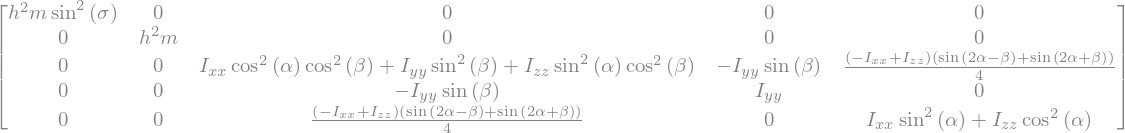

In [121]:
exp = sym.simplify(lin_sm.M)
print_and_copy(exp)
exp

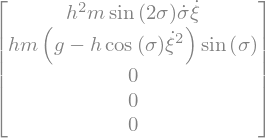

In [122]:
exp = sym.simplify(lin_sm.f)
print_and_copy(exp)
exp

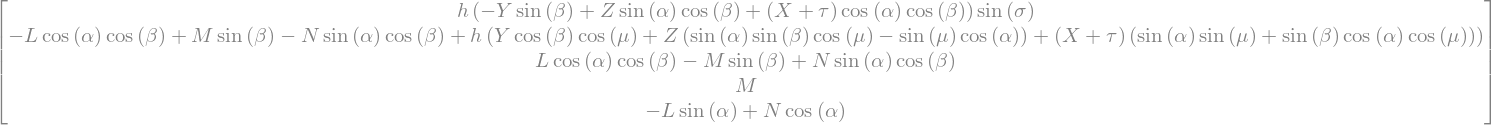

In [123]:
exp = sym.simplify(lin_sm.ExtForces.Q())
print_and_copy(exp)
exp

In [124]:
# to matlab!
file_dir = 'C:\\Git\\AlbatrossOneNastran\\matlab\\+gen_vlm\\+TetheredBodyFrame\\'
sm.to_matlab_file(p,file_dir)

### Constant Cone Angle


In [151]:
cone_sm = sm.msubs(subs)#.subs({alpha:0,beta:0,mu:0})

In [160]:
zero_Moment = {p.L:0,p.M:0,p.N:0}
Q = cone_sm.subs({i.diff(me.dynamicsymbols._t):0 for i in qs[1:]}).subs(zero_Moment).ExtForces.Q()
M = cone_sm.subs({i.diff(me.dynamicsymbols._t):0 for i in qs[1:]}).subs(zero_Moment).M
f = cone_sm.subs({i.diff(me.dynamicsymbols._t):0 for i in qs[1:]}).subs(zero_Moment).f
zeros = sym.Matrix([0,0,0,0,0])
zeros[0] = M[0,0]*qs[0].diff(t,2)

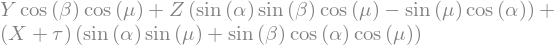

In [161]:
F_t = me.msubs(F,subs)
F_t[1]

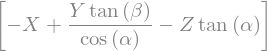

In [162]:
sym.solve(F_t[0],p.tau)

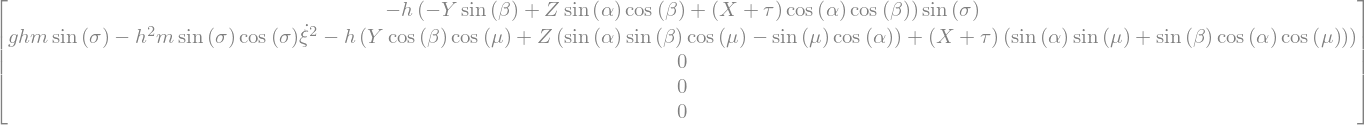

In [163]:
exp = f-Q
print_and_copy(exp)
exp

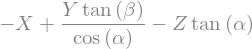

In [167]:
thrust = sym.solve(exp[0],p.tau)[0]
print_and_copy(thrust)
thrust

In [168]:
print_and_copy(sym.simplify(exp[1]))
exp[1]

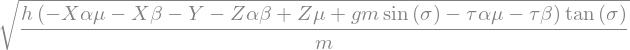

In [176]:
V = sym.Symbol('V')
hor = exp[1]
hor = hor.subs({sym.sin(i):i for i in [alpha,beta,mu]}).subs({sym.cos(i):1 for i in [alpha,beta,mu]})
v_exp = hor.subs({qs[0].diff(t):V/(p.h*sym.sin(qs[1]))})
cone_velocity = sym.simplify(sym.solve(v_exp,V)[0])
print_and_copy(cone_velocity)
cone_velocity

### Create Function to Calculate Body Velocity

In [141]:
v_body = body_frame.Translate(x,y,z).simplify().BodyVelocity()
vb = sym.Matrix(v_body[0:3])

In [142]:
def sm_to_matlab_file(sm,p,expr,func_name,file_dir):
    with open(file_dir+f"{func_name}.m",'w') as file:
        file.write(sm._gen_octave(expr,p,func_name).replace(f'function out = {func_name}(U,p)',f'function out = {func_name}(U,x,y,z,p)'))

In [143]:
file_dir = 'C:\\Git\\AlbatrossOneNastran\\matlab\\+gen_vlm\\+TetheredBodyFrame\\'
sm_to_matlab_file(sm,p,vb,'get_V',file_dir)

In [144]:
# sm_to_matlab_file(sm,p,me.msubs(vb.diff(me.dynamicsymbols._t),{i:0 for i in p.qdd}),'get_Acc',file_dir)
acc = body_frame.Transform_point([x,y,z])
sm_to_matlab_file(sm,p,me.msubs(acc,{i:0 for i in p.qdd}),'get_p',file_dir)

### Wingtip Acceleration

In [145]:
def sm_R_to_matlab_file(sm,p,expr,func_name,file_dir):
    with open(file_dir+f"{func_name}.m",'w') as file:
        file.write(sm._gen_octave(expr,p,func_name))

In [146]:
# get rotation matrix from spatial to body
sm_R_to_matlab_file(sm,p,me.msubs(body_frame.Inverse().R,{p.q[0]:0}),'get_Rot_bs',file_dir)

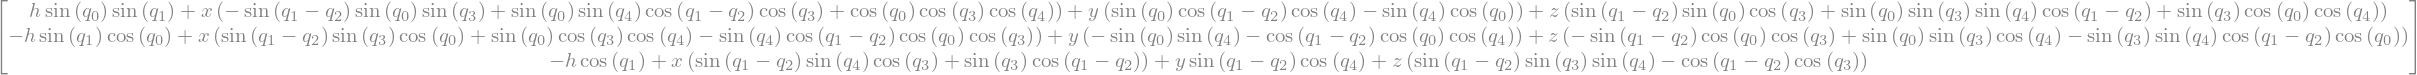

In [150]:
acc